In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

In [7]:
from tensorflow.keras.models import load_model

# Load the saved model
model = load_model('/content/drive/MyDrive/Data/lstm_stock_model.h5', compile=False)


In [8]:
import pickle
# Load scaler from disk
with open('/content/drive/MyDrive/Data/scaler.pkl', 'rb') as f:
    scaler = pickle.load(f)


In [9]:
import pandas as pd
data = pd.read_csv('/content/drive/MyDrive/Data/tsla.csv')
data.head()

,Date,Close,High,Low,Open,Volume
0,2015-07-01,17.943333,18.174667,17.856667,18.073999,31518000
1,2015-07-02,18.667999,18.830000,18.220667,18.680000,107458500
2,2015-07-06,18.648001,18.779333,18.420000,18.591999,61828500
3,2015-07-07,17.858667,18.346666,17.384666,18.333332,91576500
4,2015-07-08,16.997334,17.386667,16.954000,17.288000,93316500


In [10]:
data.set_index('Date', inplace=True)

In [11]:
data.head()

,Close,High,Low,Open,Volume
Date,,,,,
2015-07-01,17.943333,18.174667,17.856667,18.073999,31518000
2015-07-02,18.667999,18.830000,18.220667,18.680000,107458500
2015-07-06,18.648001,18.779333,18.420000,18.591999,61828500
2015-07-07,17.858667,18.346666,17.384666,18.333332,91576500
2015-07-08,16.997334,17.386667,16.954000,17.288000,93316500


In [12]:
data.shape

(2535, 5)

In [13]:
feature_col = 'Close'
n_steps = 10

In [14]:
values = data[[feature_col]].values

In [15]:
scaled = scaler.fit_transform(values)

In [16]:
# 4. Create sequences
def create_sequences(series, n_steps):
    X, y = [], []
    for i in range(len(series) - n_steps):
        X.append(series[i:i+n_steps])
        y.append(series[i+n_steps])
    return np.array(X), np.array(y)

X, y = create_sequences(scaled, n_steps)
X = X.reshape((X.shape[0], X.shape[1], 1))

In [17]:
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

In [18]:
# Predict on test set
y_pred_test = model.predict(X_test)

# Inverse scale predictions and actual values
y_pred_test_inv = scaler.inverse_transform(y_pred_test)
y_test_inv = scaler.inverse_transform(y_test)

# Calculate residuals
residuals = y_test_inv.flatten() - y_pred_test_inv.flatten()

# Calculate standard deviation of residuals
std_dev = np.std(residuals)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step


In [19]:
forecast = scaler.inverse_transform(np.array(y_pred_test).reshape(-1, 1))
forecast

array([[261.81375],
       [261.9614 ],
       [255.96754],
       [259.40955],
       [263.14105],
       [260.58737],
       [253.85698],
       [254.09389],
       [252.25922],
       [249.76207],
       [247.64648],
       [242.20055],
       [241.64998],
       [240.81812],
       [238.70132],
       [233.44102],
       [226.3005 ],
       [219.45224],
       [214.86461],
       [222.787  ],
       [228.77582],
       [233.90955],
       [231.47322],
       [234.22548],
       [236.42433],
       [248.10681],
       [253.10654],
       [255.57898],
       [247.4417 ],
       [249.80212],
       [249.97937],
       [249.40863],
       [247.14737],
       [261.02768],
       [263.83905],
       [267.2717 ],
       [271.37546],
       [271.77615],
       [265.22815],
       [262.47006],
       [260.00415],
       [254.86649],
       [245.61206],
       [243.00708],
       [241.78221],
       [239.47514],
       [242.07289],
       [246.2626 ],
       [248.9175 ],
       [246.35617],


In [20]:
n_steps = 10  # match model input
#last_sequence = data[-n_steps:].values.reshape(-1, 1)
last_sequence = data['Close'].values[-n_steps:].reshape(-1, 1)

last_sequence_scaled = scaler.transform(last_sequence)


In [21]:
def forecast_future(model, last_sequence, n_future_steps, scaler):
    future_predictions = []
    current_sequence = last_sequence.copy()

    for _ in range(n_future_steps):
        # Reshape to match model input: (1, n_steps, 1)
        input_seq = current_sequence.reshape((1, current_sequence.shape[0], 1))
        next_pred = model.predict(input_seq, verbose=0)[0]
        future_predictions.append([next_pred[0]])

        # Append the prediction and slide the window
        current_sequence = np.append(current_sequence[1:], [next_pred], axis=0)

    # Inverse scale predictions to original range
    future_predictions = scaler.inverse_transform(future_predictions)
    return future_predictions.flatten()


In [22]:
n_future_steps = 180
future = forecast_future(model, last_sequence_scaled, n_future_steps, scaler)

In [23]:
# Calculate 95% confidence intervals
upper_bound = forecast.flatten() + 1.96 * std_dev
lower_bound = forecast.flatten() - 1.96 * std_dev


In [24]:
# Flatten and take only last 180 values to match future_dates
forecast = np.array(forecast).flatten()[-180:]
lower_bound = np.array(lower_bound).flatten()[-180:]
upper_bound = np.array(upper_bound).flatten()[-180:]

In [25]:
data.index = pd.to_datetime(data.index)
data.head()

,Close,High,Low,Open,Volume
Date,,,,,
2015-07-01,17.943333,18.174667,17.856667,18.073999,31518000
2015-07-02,18.667999,18.830000,18.220667,18.680000,107458500
2015-07-06,18.648001,18.779333,18.420000,18.591999,61828500
2015-07-07,17.858667,18.346666,17.384666,18.333332,91576500
2015-07-08,16.997334,17.386667,16.954000,17.288000,93316500


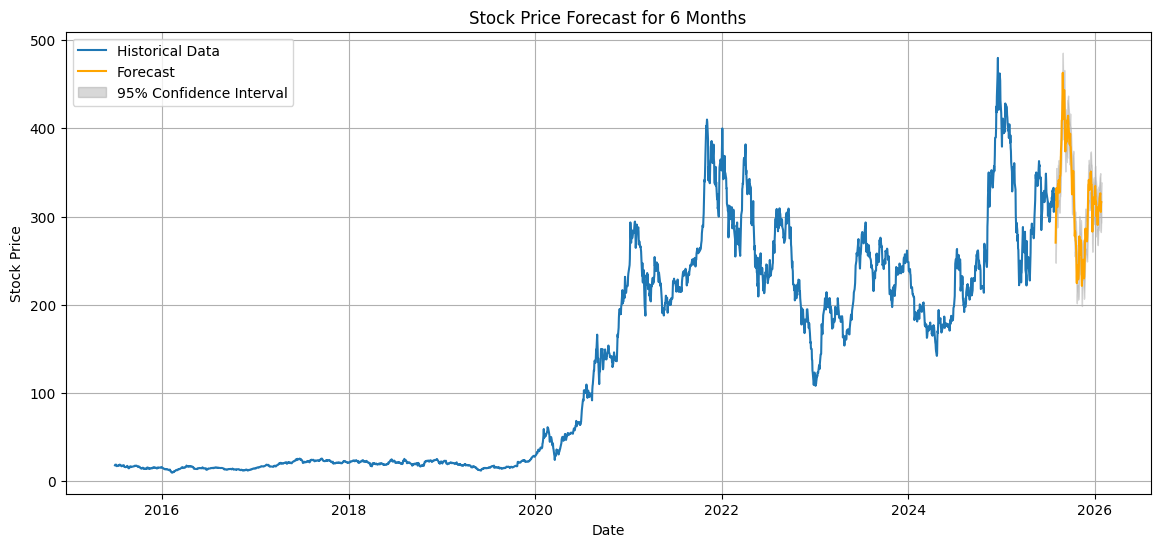

In [26]:
import matplotlib.pyplot as plt
import pandas as pd
from datetime import timedelta

# Create future dates
last_date = data.index[-1]
future_dates = [last_date + timedelta(days=i) for i in range(1, 181)]

plt.figure(figsize=(14,6))
plt.plot(data.index, data['Close'], label='Historical Data')
plt.plot(future_dates, forecast, label='Forecast', color='orange')
plt.fill_between(future_dates, lower_bound, upper_bound, color='gray', alpha=0.3, label='95% Confidence Interval')
plt.title("Stock Price Forecast for 6 Months")
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.legend()
plt.grid(True)
plt.show()


Interpretation:
### Consistent Volatility

The forecast line oscillates (goes up and down regularly), this means the model expects continued volatility — but within a familiar range.

This can be common in tech stocks like Tesla, where prices often fluctuate around earnings, announcements, or macroeconomic changes.

### No Drastic Trend Change

Since the forecast resembles the last 6 months, there's no expected major upward or downward breakout.

Investors or stakeholders might see this as a period of consolidation or stability.

###Possible Strategy Insight

The forecast could suggest short-term swing trading opportunities or holding off long-term decisions until a clearer breakout is seen.

In [27]:
# ----- Forecast checks -----
forecast = np.array(forecast).flatten()
print("\n>>> Forecast info")
print("Forecast length:", forecast.shape[0])
print("Any NaN in forecast?", np.isnan(forecast).any())
print("Any Inf in forecast?", np.isinf(forecast).any())


>>> Forecast info
Forecast length: 180
Any NaN in forecast? False
Any Inf in forecast? False


In [44]:
bnd_df = pd.read_csv('/content/drive/MyDrive/Data/bnd.csv')
spy_df = pd.read_csv('/content/drive/MyDrive/Data/spy.csv')
tsla_df = pd.read_csv('/content/drive/MyDrive/Data/tsla.csv')

In [29]:
pred_df = pd.DataFrame(future, columns=['Close'])
pred_df.head()

,Close
0,314.517337
1,310.213515
2,305.594960
3,301.231600
4,297.022971


In [45]:
pred_df['Daily Return'] = pred_df['Close'].pct_change()
tsla_df['Daily Return'] = tsla_df['Close'].pct_change()
bnd_df['Daily Return'] = bnd_df['Close'].pct_change()
spy_df['Daily Return'] = spy_df['Close'].pct_change()

In [50]:
pred_df.head()

,Close,Daily Return
Date,,
2025-08-01,305.594960,-0.014888
2025-08-04,301.231600,-0.014278
2025-08-05,297.022971,-0.013971
2025-08-06,293.025528,-0.013458
2025-08-07,289.221218,-0.012983


In [47]:
bnd_df.set_index('Date', inplace=True)
spy_df.set_index('Date', inplace=True)
tsla_df.set_index('Date', inplace=True)

In [49]:
tsla_df.dropna(inplace=True)
bnd_df.dropna(inplace=True)
spy_df.dropna(inplace=True)
pred_df.dropna(inplace=True)

Annualized Return

In [51]:
# Annualized return formula: mean daily return * 252 (trading days in a year)
bnd_annual_return = bnd_df['Daily Return'].mean() * 252
spy_annual_return = spy_df['Daily Return'].mean() * 252
tsla_annual_return = tsla_df['Daily Return'].mean() * 252

print("BND Annualized Return:", bnd_annual_return)
print("SPY Annualized Return:", spy_annual_return)
print("TSLAPY Annualized Return:", tsla_annual_return)

BND Annualized Return: 0.0195993633813665
SPY Annualized Return: 0.14484444649909195
TSLAPY Annualized Return: 0.46068980411103705


In [52]:
# Calculate the average daily return from predictions
avg_daily_return_tsla = pred_df['Daily Return'].mean()

# Annualize the predicted return (252 trading days in a year)
tsla_expected_annual_return = avg_daily_return_tsla * 252

print("TSLA Expected Annualized Return (from forecast):", tsla_expected_annual_return)

TSLA Expected Annualized Return (from forecast): -0.6418622770343548


In [53]:
import numpy as np
from scipy.optimize import minimize

# Inputs (replace with your actual values)
tsla_expected_return = tsla_expected_annual_return  # from forecast step
bnd_expected_return = bnd_annual_return            # from historical step
spy_expected_return = spy_annual_return            # from historical step

In [54]:
# 1. Last historical Tesla date (assumes tsla_df has historical data with datetime index)
last_hist_date = data.index[-1]

# 2. Create forecast date range starting from next day
forecast_dates = pd.date_range(start=last_hist_date + pd.Timedelta(days=1), periods=len(pred_df), freq='B')  # 'B' for business days

# 3. Assign forecast dates as index of Tesla prediction df
pred_df.index = forecast_dates

In [56]:
pred_df.index.rename('Date', inplace=True)

In [57]:
pred_df.head()

,Close,Daily Return
Date,,
2025-07-31,305.594960,-0.014888
2025-08-01,301.231600,-0.014278
2025-08-04,297.022971,-0.013971
2025-08-05,293.025528,-0.013458
2025-08-06,289.221218,-0.012983


In [60]:
# 4. Rename 'Daily Return' column and proceed to combine
tsla_returns = tsla_df['Daily Return'].rename('TSLA')
bnd_returns = bnd_df['Daily Return'].rename('BND')
spy_returns = spy_df['Daily Return'].rename('SPY')

# 5. Join on date index (inner join to keep only overlapping dates)
hist_daily_returns = pd.concat([tsla_returns, bnd_returns, spy_returns], axis=1).dropna()

print(hist_daily_returns.head())


                TSLA       BND       SPY
Date                                    
2015-07-02  0.040386  0.002472 -0.000916
2015-07-06 -0.001071  0.003453 -0.002846
2015-07-07 -0.042328  0.000983  0.006288
2015-07-08 -0.048231  0.002824 -0.016777
2015-07-09  0.011610 -0.003306  0.001809


In [61]:
# Historical daily returns DataFrame with columns ['TSLA', 'BND', 'SPY']
# Example: hist_daily_returns

TRADING_DAYS = 252
risk_free_rate = 0.025  # example 2.5% annual risk-free rate

# Expected returns vector
expected_returns = np.array([tsla_expected_return, bnd_expected_return, spy_expected_return])

# Covariance matrix annualized
cov_matrix = hist_daily_returns[['TSLA', 'BND', 'SPY']].cov() * TRADING_DAYS
cov_matrix = cov_matrix.values

In [62]:
# Portfolio metrics
def portfolio_return(weights):
    return np.dot(weights, expected_returns)

def portfolio_volatility(weights):
    return np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))

def sharpe_ratio(weights):
    ret = portfolio_return(weights)
    vol = portfolio_volatility(weights)
    return (ret - risk_free_rate) / vol

# Constraints and bounds (weights sum to 1, weights between 0 and 1)
constraints = {'type': 'eq', 'fun': lambda x: np.sum(x) - 1}
bounds = [(0, 1) for _ in range(3)]

In [63]:
bounds

[(0, 1), (0, 1), (0, 1)]

In [64]:
constraints

{'type': 'eq', 'fun': <function __main__.<lambda>(x)>}

In [65]:
# Objective functions
def min_volatility(weights):
    return portfolio_volatility(weights)

def neg_sharpe(weights):
    return -sharpe_ratio(weights)

# Initial guess: equally weighted
init_guess = np.array([1/3] * len(expected_returns))

# Minimize volatility portfolio
opt_min_vol = minimize(min_volatility, init_guess, method='SLSQP', bounds=bounds, constraints=constraints)
weights_min_vol = opt_min_vol.x

In [66]:
# Maximize Sharpe ratio portfolio
opt_max_sharpe = minimize(neg_sharpe, init_guess, method='SLSQP', bounds=bounds, constraints=constraints)
weights_max_sharpe = opt_max_sharpe.x

In [67]:
# Function to print portfolio details
def print_portfolio(weights, name):
    ret = portfolio_return(weights)
    vol = portfolio_volatility(weights)
    sr = sharpe_ratio(weights)
    assets = ['TSLA', 'BND', 'SPY']
    print(f"\n{name}:")
    for asset, w in zip(assets, weights):
        print(f"  {asset}: {w:.2%}")
    print(f"Expected Annual Return: {ret:.2%}")
    print(f"Annual Volatility: {vol:.2%}")
    print(f"Sharpe Ratio: {sr:.3f}")

In [68]:
# Print results
print_portfolio(weights_min_vol, "Minimum Volatility Portfolio")
print_portfolio(weights_max_sharpe, "Maximum Sharpe Ratio Portfolio")


Minimum Volatility Portfolio:
  TSLA: 0.00%
  BND: 94.52%
  SPY: 5.48%
Expected Annual Return: 2.65%
Annual Volatility: 5.40%
Sharpe Ratio: 0.027

Maximum Sharpe Ratio Portfolio:
  TSLA: 0.00%
  BND: 0.00%
  SPY: 100.00%
Expected Annual Return: 14.48%
Annual Volatility: 18.24%
Sharpe Ratio: 0.657


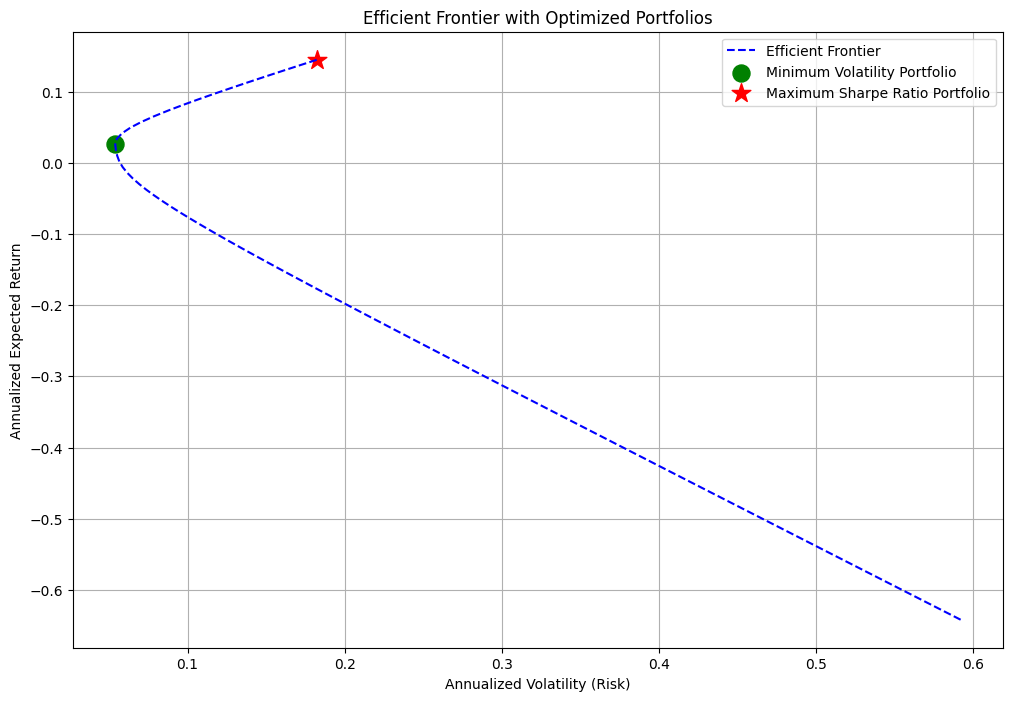

In [69]:
import matplotlib.pyplot as plt

def portfolio_volatility(weights):
    return np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))

def portfolio_return(weights):
    return np.dot(weights, expected_returns)

# Generate points on the efficient frontier
def efficient_frontier(expected_returns, cov_matrix, num_points=100):
    results = np.zeros((3, num_points))
    bounds = [(0, 1) for _ in range(len(expected_returns))]
    constraints = {'type': 'eq', 'fun': lambda x: np.sum(x) - 1}
    init_guess = np.array([1/len(expected_returns)] * len(expected_returns))

    for i, target_return in enumerate(np.linspace(expected_returns.min(), expected_returns.max(), num_points)):
        cons = (
            constraints,
            {'type': 'eq', 'fun': lambda x: portfolio_return(x) - target_return}
        )
        res = minimize(portfolio_volatility, init_guess, method='SLSQP', bounds=bounds, constraints=cons)
        if res.success:
            results[0, i] = res.fun  # volatility
            results[1, i] = target_return
            results[2, i] = (target_return - risk_free_rate) / res.fun  # Sharpe ratio
        else:
            results[:, i] = np.nan
    return results

# Calculate efficient frontier points
ef_results = efficient_frontier(expected_returns, cov_matrix)

plt.figure(figsize=(12, 8))

# Plot Efficient Frontier
plt.plot(ef_results[0], ef_results[1], 'b--', label='Efficient Frontier')

# Plot Minimum Volatility Portfolio
plt.scatter(portfolio_volatility(weights_min_vol), portfolio_return(weights_min_vol),
            marker='o', color='green', s=150, label='Minimum Volatility Portfolio')

# Plot Maximum Sharpe Ratio Portfolio
plt.scatter(portfolio_volatility(weights_max_sharpe), portfolio_return(weights_max_sharpe),
            marker='*', color='red', s=200, label='Maximum Sharpe Ratio Portfolio')

plt.title('Efficient Frontier with Optimized Portfolios')
plt.xlabel('Annualized Volatility (Risk)')
plt.ylabel('Annualized Expected Return')
plt.legend()
plt.grid(True)
plt.show()


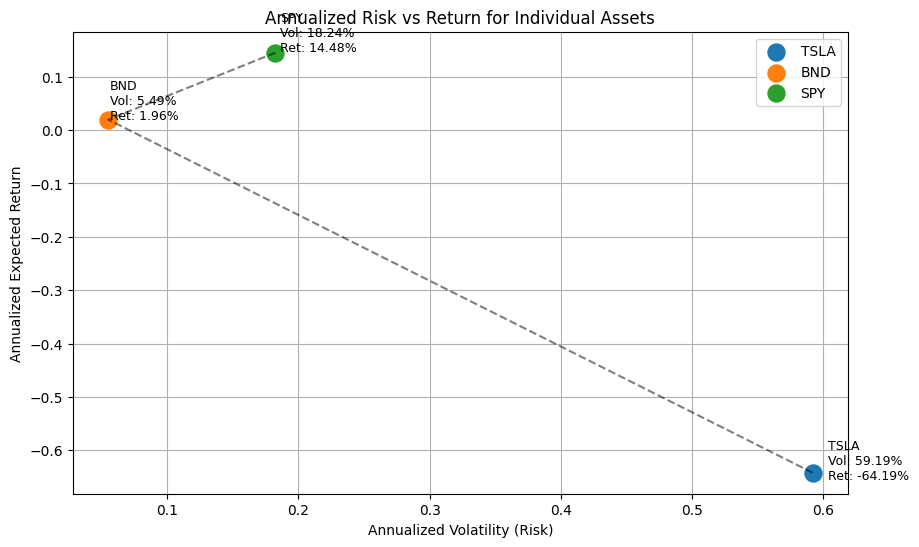

In [72]:
import matplotlib.pyplot as plt

# Calculate individual assets' volatility and returns
asset_volatility = np.sqrt(np.diag(cov_matrix))
asset_returns = expected_returns
assets = ['TSLA', 'BND', 'SPY']

plt.figure(figsize=(10,6))

# Plot points and annotate
for i, asset in enumerate(assets):
    plt.scatter(asset_volatility[i], asset_returns[i], marker='o', s=150, label=asset)
    plt.text(asset_volatility[i]*1.02, asset_returns[i]*1.02,
             f"{asset}\nVol: {asset_volatility[i]:.2%}\nRet: {asset_returns[i]:.2%}",
             fontsize=9)

# Draw lines connecting the points
plt.plot(asset_volatility, asset_returns, 'k--', alpha=0.5)

plt.title('Annualized Risk vs Return for Individual Assets')
plt.xlabel('Annualized Volatility (Risk)')
plt.ylabel('Annualized Expected Return')
plt.legend()
plt.grid(True)
plt.show()
